### focus stacking w.r.t. distance from focus

In [1]:
import numpy as np
import subprocess
import glob
import skimage.io as imio
import re
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
%matplotlib inline
import time



In [2]:
## camera behavior
def initialFocus(sid=0):
    #10.42.0.90: local 10.236.176.75: ip
    cmD='ssh nvidia@10.236.176.75 "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -init "'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def moveFocus(sid=0, pos=512):
    cmD='ssh nvidia@10.236.176.75 "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -mod '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout
def setFocus(sid=0, pos=512):
    cmD='ssh nvidia@10.236.176.75 "echo "nvidia" | sudo -S ~/Documents/cam_on_Tegra/testCamera -id '+str(sid)+' -set '+str(pos)+'"'
    pop=subprocess.run(cmD, stdout=subprocess.PIPE, shell=True)
    return pop.stdout

def grab_image(sid=0, imres=8):
# I will use the file name dbGrab.... for the image grabbed from the camera. First step is to get rid of previously grabbed images

    subprocess.run('ssh nvidia@10.236.176.75 "rm dbGrab*"', \
                   stdout=subprocess.PIPE, shell=True)

    # ok, now let's grab an image on the tegra
    subprocess.run('ssh nvidia@10.236.176.75 "nvgstcapture-1.0 -m 1 --sensor-id '+str(sid)+' -A --capture-auto 1 \
                    --file-name dbGrab --image-res '+str(imres)+'"', stdout=subprocess.PIPE, shell=True)
    subprocess.run('scp nvidia@10.236.176.75:dbGrab* .', \
                   stdout=subprocess.PIPE, shell=True)
    #ok, now let's find the file name of the image we just grabbed and transfered 
    pop=subprocess.run('ls',stdout=subprocess.PIPE, shell=True)
    rePop=pop.stdout
    rePop=rePop.decode("utf-8")
    fileName = re.search(r'dbGrab(.*).jpg', rePop)
    fileName=fileName.group()
    pop=imio.imread(fileName)
#     pop=skimage.transform.rotate(pop,180)
    subprocess.run('mv dbGrab* photo_arch/', \
                   stdout=subprocess.PIPE, shell=True)
    
    return pop

In [3]:
from quad_solver import solver
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import cv2

class pixel_estimator_with_weights(nn.Module):
    def __init__(self, Weights,device = "cuda:0"):
        ## Default: gpu mode
        super(pixel_estimator_with_weights, self).__init__()
        self.device = torch.device(device)
        self.w1 = torch.from_numpy(Weights[0].transpose(3,2,0,1)).to(self.device)
        self.b1 = torch.from_numpy(Weights[1]).to(self.device)
        self.w2 = torch.tensor(Weights[2].transpose(3,2,0,1)).to(self.device)
        self.b2 = torch.tensor(Weights[3]).to(self.device)
        self.w3 = torch.tensor(Weights[4].transpose(3,2,0,1)).to(self.device)
        self.b3 = torch.tensor(Weights[5]).to(self.device)
        self.w4 = torch.tensor(Weights[6]).reshape(4,4,8,1024).permute(3,2,0,1).to(self.device)
        self.b4 = torch.tensor(Weights[7]).to(self.device)
        self.w5 = torch.tensor(Weights[8]).reshape(1,1,1024,512).permute(3,2,0,1).to(self.device)
        self.b5 = torch.tensor(Weights[9]).to(self.device)
        self.w6 = torch.tensor(Weights[10]).reshape(1,1,512,10).permute(3,2,0,1).to(self.device)
        self.b6 = torch.tensor(Weights[11]).to(self.device)
        self.w7 = torch.tensor(Weights[12]).reshape(1,1,10,1).permute(3,2,0,1).to(self.device)
        self.b7 = torch.tensor(Weights[13]).to(self.device)

    def forward(self, x):
        x = F.relu(F.conv2d(x,self.w1,bias = self.b1,stride=1))
        x = F.relu(F.conv2d(x,self.w2,bias = self.b2,stride=1,dilation=8))
        x = F.relu(F.conv2d(x,self.w3,bias = self.b3,stride=1,dilation=32))
        x = F.leaky_relu(F.conv2d(x,self.w4,bias = self.b4,stride=1,dilation=128),0.1)
        x = F.leaky_relu(F.conv2d(x,self.w5,bias = self.b5,stride=1),0.1)
        x = F.leaky_relu(F.conv2d(x,self.w6,bias = self.b6,stride=1),0.1)
        x = F.conv2d(x,self.w7,bias = self.b7,stride=1)
        return x
    
model = torch.load('autofocus.pth')
model.eval()

def save_imgs(imgs, curr):
    t = int(time.time()%100000)

    for i, img in enumerate(imgs):
        cv2.imwrite("static_fs/{:d}_s{}_{:02d}.jpg".format(t, curr, i), img[..., ::-1])

In [4]:
def crop_patches(img, window= 1023, step = 512):
    patches = []
    H, W = img.shape
    for i in range(0, H-step, step):
        for j in range(0, W-step, step):
            patches.append(img[i:i+window, j:j+window])
    return np.stack(patches)

def dist_est(img, curr = 1000, last_dist_map = None, last_move_steps = None):
    img = np.pad(img, ((200, 200), (128, 128)), 'reflect')
    plt.imshow(img)
    plt.show()
    H, W = img.shape
    
    patches = crop_patches(img)
    patches = torch.from_numpy(patches).float().unsqueeze(1).cuda()

    results = []
    with torch.no_grad():
        for i in range(patches.size()[0]):
            results.append(model(patches[i:i+1]))
    results = torch.stack(results)

    results = results.cpu().numpy()
    results = results.squeeze()
    
    if last_dist_map is None:
        last_dist_map = np.ones((H-512, W-512))

    k = 0
    sigma =1
    n_img = np.zeros((H-512, W-512))
    for i in range(0, H-512, 512):
        for j in range(0, W-512, 512):
            n_img[i:i+512, j:j+512] = results[k]
            k += 1
    n_img[n_img < sigma] = 0
    n_img[last_dist_map==0]=0

        
    plt.imshow((n_img < sigma).astype(np.float32), cmap = 'gray')
    #plt.colorbar()
    #plt.show()
    plt.savefig('static_fs/{}.jpg'.format(int(time.time()%100000)))
#     plt.hist(n_img.flatten(), bins = 10)
#     plt.show()

    if last_move_steps is not None:
        ## Focus direction: simple check
        mapa = n_img - last_move_steps
        mapb = -n_img - last_move_steps
        diffa = np.abs(mapa) - last_dist_map
        diffb = np.abs(mapb) - last_dist_map
        mask = (np.abs(diffa) < np.abs(diffb)).astype(np.float64)
        n_img = (n_img * mask + (1-mask) * (-n_img))
        
    dist_vec = n_img.flatten()
    dist_vec = dist_vec[dist_vec!=0]
    #dist_vec = dist_vec[np.abs(dist_vec)>1.5]
    plt.figure()
    n, bins, patches = plt.hist(dist_vec, bins=15)

    idx_sorted = np.argsort(n)[::-1]
    flag = False
    for i in range(len(n)):
        dist_to_move = -(bins[idx_sorted[i]]+bins[idx_sorted[i]+1])/2
        #print("trial {}: est curr: {}".format(i, curr + solver(curr, dist_to_move)))
        if (curr + solver(curr, dist_to_move) > 375) and (curr + solver(curr, dist_to_move) < 1100):
            flag = True
            break
    plt.show()

    return flag, np.abs(n_img), dist_to_move

In [5]:
curr = 1000
# setFocus(pos = curr)
# img = grab_image()
# plt.figure(figsize=(10., 8.))
# plt.imshow(img)
# plt.show()

dist_map = None
dist_to_move = None

round:  0


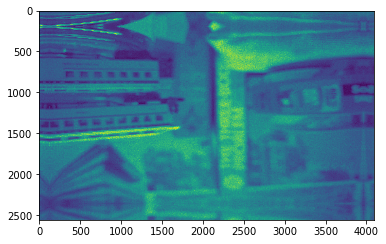

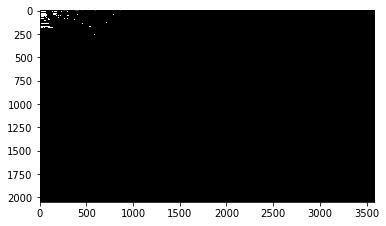

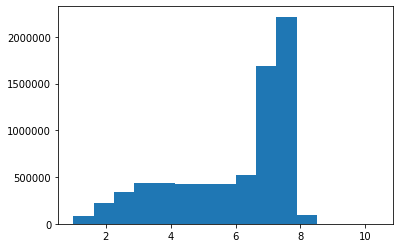

distance to move:  -7.567628574371337
round 1 -- current focus pos is: 541.767580233327
round:  1


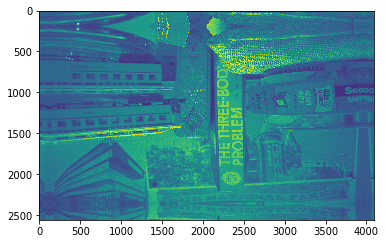

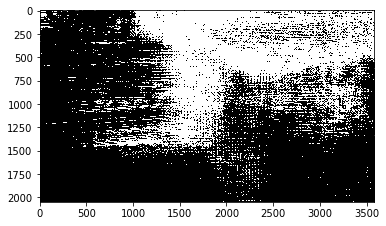

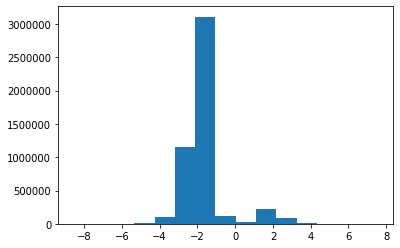

distance to move:  1.5832223574320485
round 2 -- current focus pos is: 607.2838560258975
round:  2


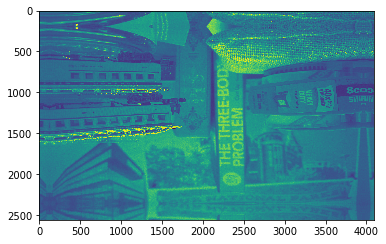

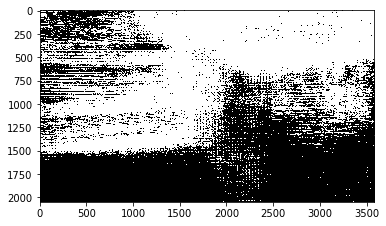

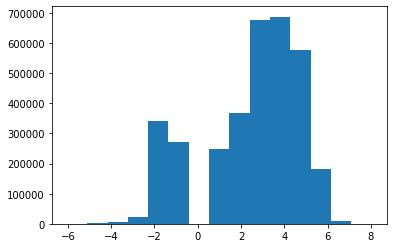

distance to move:  -3.8040703296661373
round 3 -- current focus pos is: 459.6404005004197
round:  3


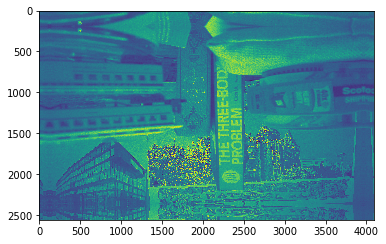

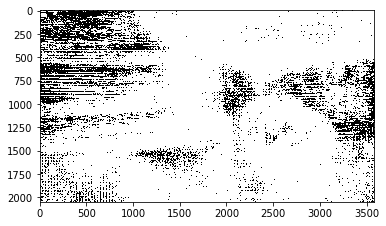

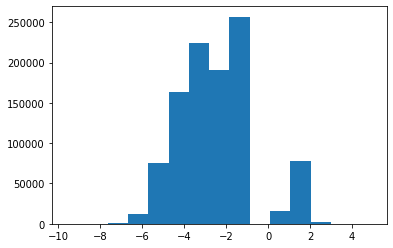

distance to move:  1.3607718149820962
round 4 -- current focus pos is: 508.79426320544917
round:  4


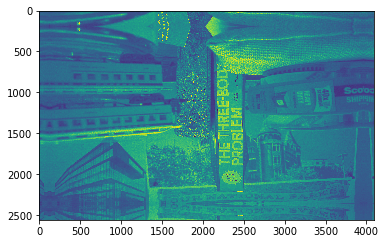

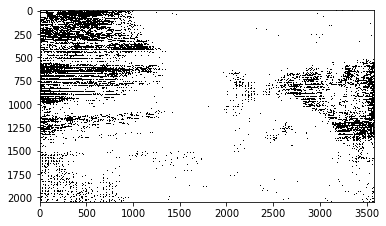

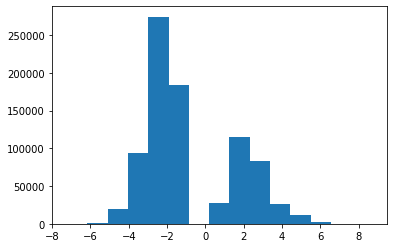

distance to move:  2.44953670501709
break curr1:  607.5564601711162


In [6]:
imgs = []
currs = [1000]
for i in range(10):
    print("round: ", i)

    setFocus(pos = curr)
    img = grab_image()
    imgs.append(img)
    gray_img = rgb2gray(img)

    flag, dist_map, dist_to_move = dist_est(gray_img, curr, dist_map, dist_to_move)

    if flag is False:
        break
    print("distance to move: ", dist_to_move)
    curr = curr + solver(curr, dist_to_move)
    curr = np.clip(curr, 450, 1000)
    if np.abs(curr - currs[-1]) > 50 and np.abs(curr - np.stack(currs)).min() < 50:
        print("break curr1: ", curr)
        break
    elif (curr==450 and np.stack(currs).min() < 475):
        print("break curr2: ", curr)
        break
    else:
        currs.append(curr)
    
    print("round {} -- current focus pos is: {}".format(i+1, curr))
    
imgs = np.stack(imgs)
#     print(dist_map)
save_imgs(imgs, currs[0])